In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
# from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
#importing required datasets
from google.colab import drive
import os
drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/cats_dogs1'


Mounted at /content/drive


In [3]:
commands = ['cat', 'dog']
print(commands)

filenames = tf.io.gfile.glob(data_dir + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Example file tensor:', filenames[0])

['cat', 'dog']
Number of total examples: 277
Example file tensor: tf.Tensor(b'/content/drive/My Drive/cats_dogs1/dog/dog_barking_104.wav', shape=(), dtype=string)


In [4]:
train_files = filenames[:150]
val_files = filenames[150: 150 + 77]
test_files = filenames[-50:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 150
Validation set size 77
Test set size 50


In [5]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)


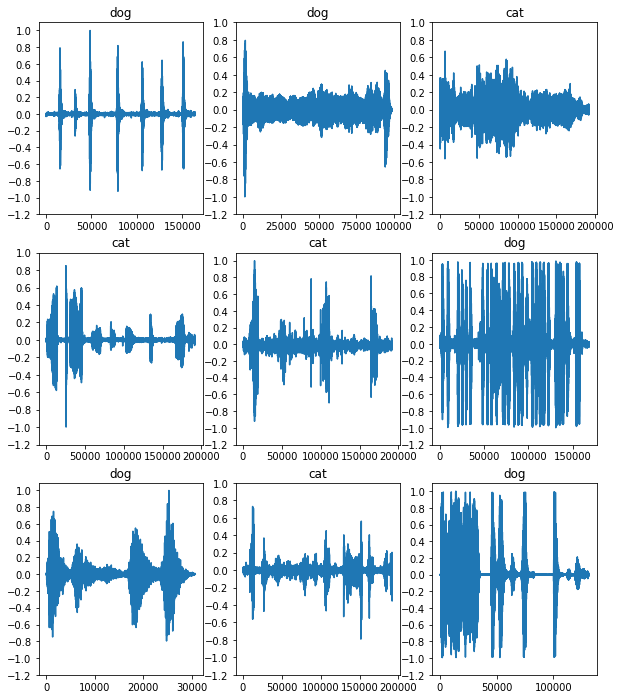

In [6]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [7]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [9]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
# print('Audio playback')
# display.display(display.Audio(waveform, rate=16000))

Label: dog
Waveform shape: (164191,)
Spectrogram shape: (124, 129, 1)


In [10]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [11]:
print(waveform.shape)

(164191,)


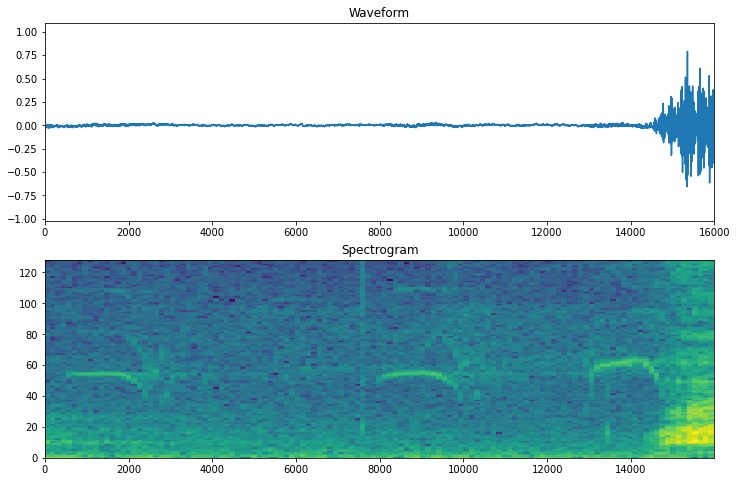

In [12]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [13]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

In [14]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

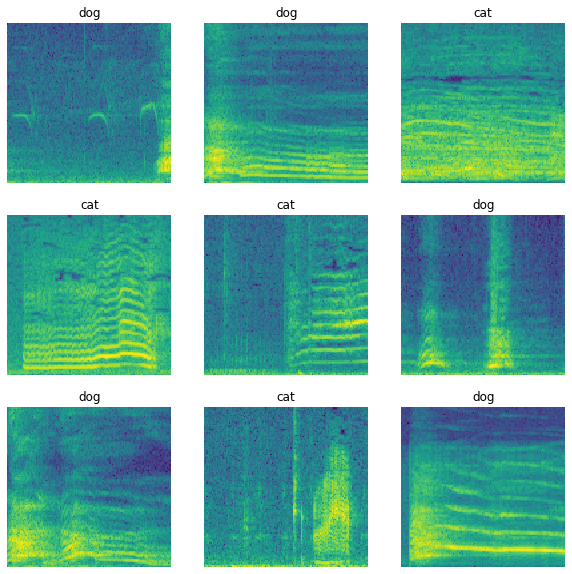

In [15]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [18]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [19]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [20]:
batch_size = 12
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [21]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [29]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(64, 64),
    # Normalize.
    norm_layer,
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


model1 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(64, 64),
    norm_layer,
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model1.summary()




Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 64, 64, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [36]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [35]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
13/13 [==============================] - 2s 146ms/step - loss: 0.6246 - accuracy: 0.7733 - val_loss: 0.3437 - val_accuracy: 0.8831
Epoch 2/10
13/13 [==============================] - 2s 134ms/step - loss: 0.4106 - accuracy: 0.8467 - val_loss: 0.3308 - val_accuracy: 0.9221
Epoch 3/10
13/13 [==============================] - 2s 146ms/step - loss: 0.3510 - accuracy: 0.8667 - val_loss: 0.2486 - val_accuracy: 0.9221
Epoch 4/10
13/13 [==============================] - 2s 148ms/step - loss: 0.2290 - accuracy: 0.9200 - val_loss: 0.2567 - val_accuracy: 0.9351
Epoch 5/10
13/13 [==============================] - 2s 136ms/step - loss: 0.1949 - accuracy: 0.9133 - val_loss: 0.2807 - val_accuracy: 0.9351
Epoch 5: early stopping


In [37]:
EPOCHS = 10
history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
13/13 [==============================] - 4s 249ms/step - loss: 0.1945 - accuracy: 0.9133 - val_loss: 0.2685 - val_accuracy: 0.8961
Epoch 2/10
13/13 [==============================] - 3s 239ms/step - loss: 0.1871 - accuracy: 0.9200 - val_loss: 0.2028 - val_accuracy: 0.9351
Epoch 3/10
13/13 [==============================] - 3s 222ms/step - loss: 0.1483 - accuracy: 0.9267 - val_loss: 0.2008 - val_accuracy: 0.9221
Epoch 4/10
13/13 [==============================] - 3s 241ms/step - loss: 0.1588 - accuracy: 0.9333 - val_loss: 0.2004 - val_accuracy: 0.9091
Epoch 5/10
13/13 [==============================] - 5s 408ms/step - loss: 0.1029 - accuracy: 0.9667 - val_loss: 0.2017 - val_accuracy: 0.9091
Epoch 6/10
13/13 [==============================] - 6s 442ms/step - loss: 0.0891 - accuracy: 0.9600 - val_loss: 0.2131 - val_accuracy: 0.9091
Epoch 6: early stopping


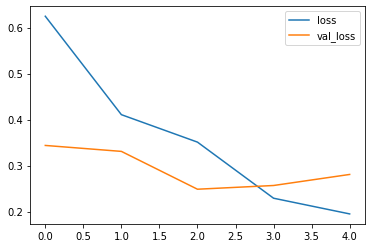

In [38]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

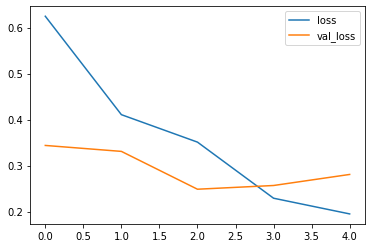

In [39]:
metrics1 = history1.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [40]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
print(test_audio[0].shape)

(124, 129, 1)


In [44]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 92%


In [43]:
y_pred1 = np.argmax(model1.predict(test_audio), axis=1)
y_true1 = test_labels

test_acc1 = sum(y_pred1 == y_true1) / len(y_true1)
print(f'Test set accuracy: {test_acc1:.0%}')

Test set accuracy: 90%


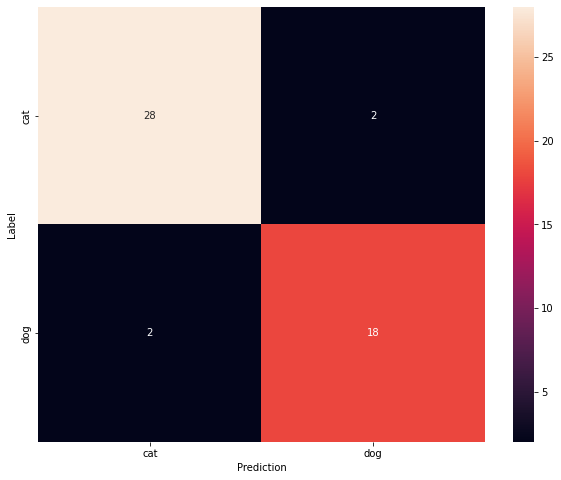

In [45]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

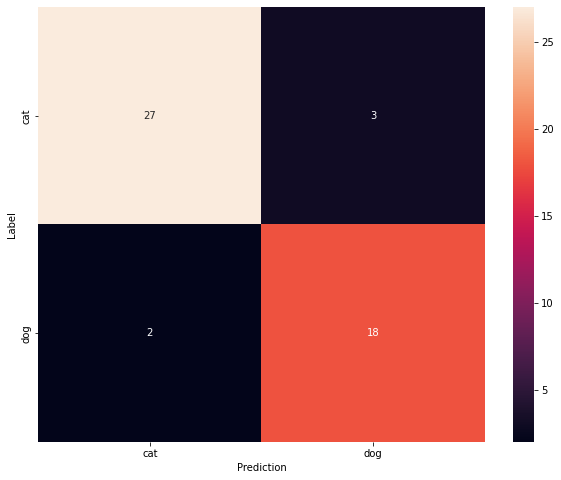

In [46]:
confusion_mtx = tf.math.confusion_matrix(y_true1, y_pred1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Real world

In [ ]:
#All imports
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import collections

In [ ]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.io.wavfile
import io
import os

#### Please comment below line, if you already uploaded the 'recording.wav' in '/content/'
!rm recording.wav

#### You can run this module in the loop to record more repetitions of the digits.
if os.path.isfile('recording.wav'):
    print("wavefile exists, later part of the code uses 'recording.wav' as input speech")
else:
    print("Recording the digits")
    wav = record(3.0) #It will record three seconds of your speech. You can change the duration. 
    wav = wav.set_frame_rate(16000)
    sig=wav.get_array_of_samples()
    samples=np.array(sig).T.astype(np.float32)
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(sig.typecode).max
    scipy.io.wavfile.write('recording.wav', 16000, fp_arr) #Please change the name.


# import scipy.io.wavfile as wav
# from python_speech_features import mfcc
# import speechpy

# sigg = MFCC('recording.wav')
# print("predicting")
# arr11, pred11 = digit_Classify(templates,sigg)
# print("pred11 : ", pred11)
# print(arr11)

rm: cannot remove 'recording.wav': No such file or directory
Recording the digits


<IPython.core.display.Javascript object>

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.io.wavfile
import io
import os

#### Please comment below line, if you already uploaded the 'recording.wav' in '/content/'
!rm recording.wav

#### You can run this module in the loop to record more repetitions of the digits.
if os.path.isfile('recording.wav'):
    print("wavefile exists, later part of the code uses 'recording.wav' as input speech")
else:
    print("Recording the digits")
    wav = record(3.0) #It will record three seconds of your speech. You can change the duration. 
    wav = wav.set_frame_rate(16000)
    sig=wav.get_array_of_samples()
    samples=np.array(sig).T.astype(np.float32)
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(sig.typecode).max
    scipy.io.wavfile.write('recording.wav', 16000, fp_arr) #Please change the name.


# import scipy.io.wavfile as wav
# from python_speech_features import mfcc
# import speechpy



Recording the digits


<IPython.core.display.Javascript object>

ValueError: ignored

In [ ]:
import scipy.io.wavfile as wav
(rate,sig) = wav.read('recording.wav')
sig = np.array(sig)
print(sig)

spec = get_spectrogram(sig)

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  6.6365581e-05
 -2.3462018e-04 -1.2872135e-04]


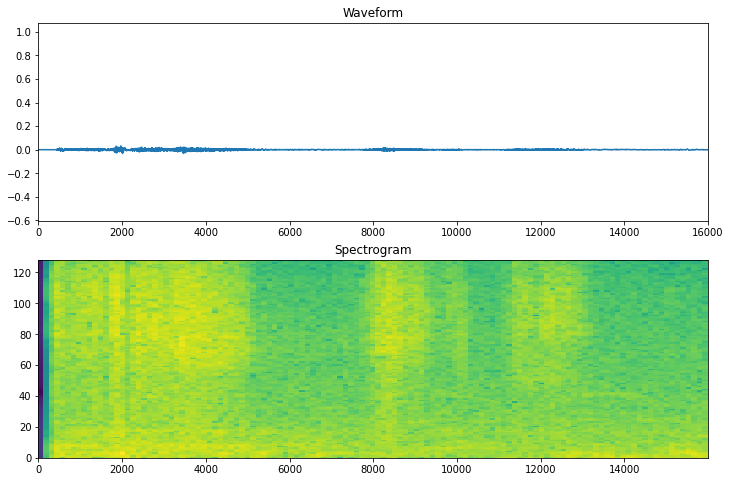

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(sig.shape[0])
axes[0].plot(timescale, sig)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spec.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
print("predicting")
y_pred = np.argmax(model.predict(spec), axis=1)
print("prediction : ", y_pred)

predicting


ValueError: ignored